In [21]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

import itertools
import helper_functions as hlf
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [22]:
# open the pre-processed csv file and split the target variable from the classifiers
df = pd.read_csv('dota2_scaled.csv')
df.head()

,Riki,Razor,Morphling,Brewmaster,Slardar,Wisp,Omniknight,Slark,Ogre Magi,Chaos Knight,...,Support,Offlane,Mid,Roamer,Nuke/Disable,High_Win,Low_Win,Most_Picked_719,Most_Picked_720,Won
0,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.493732,1.007526,1.261730,0.157217,3.185349,0.474901,-0.814275,-0.678438,-0.650247,1
1,5.253443,-0.155243,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-0.493732,1.007526,0.266544,0.157217,-0.254635,0.474901,0.667752,-0.678438,1.141562,1
2,-0.190351,6.441500,-0.186940,-0.181034,-0.187513,-0.21094,-0.183669,-0.245093,-0.197112,-0.211026,...,-1.621490,-1.304373,0.266544,-1.058379,0.892026,1.805530,-0.814275,-0.678438,-0.650247,1
3,-0.190351,6.441500,5.349299,-0.181034,-0.187513,-0.21094,5.444586,-0.245093,-0.197112,-0.211026,...,0.634025,-1.304373,-0.728642,0.157217,0.892026,-0.855727,0.667752,-0.678438,-0.650247,1
4,5.253443,-0.155243,-0.186940,5.523822,-0.187513,-0.21094,-0.183669,-0.245093,5.073260,-0.211026,...,-0.493732,-0.148424,-0.728642,0.157217,0.892026,-0.855727,-0.814275,-0.678438,1.141562,1


In [23]:
#separate the target variable
labels = df['Won']
df.drop(['Won'], axis=1, inplace=True)
# scaler = StandardScaler()
# scaler.fit(df)
# scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
# scaled_df.head()

In [24]:
# Create seprate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(scaled_df, labels, test_size=0.25)

#   KNN Model:

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# run initial model with default values
knn5 = KNeighborsClassifier()
knn5.fit(x_train, y_train.values.ravel())

knn_pred = knn5.predict(x_test)

_, _ = hlf.print_metrics(y_test, knn_pred, print_score=True)

Recall Score: 54.71
Accuracy Score: 52.6


In [ ]:
hlf.plot_confusion_matrix(y_test, knn_pred)
# plt.savefig('knn_cm.png')

In [ ]:
print(f" F1 Score (neighbors = 5): {round(f1_score(y_test, knn_pred), 2)}")

## Initial KNN model performed poorly

#### Recall Score:  52.45%

#### Accuracy Score:  52.44%

#### ROC AUC Score: 0.77

In [ ]:
def multiple_knn(df, labels, ks=[5]):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)
    best_acc = 0
    best_k = 0
    scores = []

    for k in tqdm(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train.values.ravel())
        test_predict = knn.predict(x_test)
        score = hlf.print_metrics(y_test, test_predict)
        scores.append(score)
        
        if best_acc < score[1]:
            best_acc = score[1]
            best_k = k
            
        
    return best_acc, best_k, scores

In [ ]:
# run model again k = 2, 4, 5, 6, 7
_, _, scores = multiple_knn(df, labels, ks=[2, 4, 5, 6, 7])
print(f"scores: {scores}, k: {k}")

In [ ]:
# running the model again k =  3, 5, 8, 9
_, _, scores = multiple_knn(df, labels, ks=[3, 5, 8, 9])
print(f"scores: {scores}, k: {k}")

### Optimal neighbors = 9


#### Recall - 52.98% 

#### Accuracy =  52.52%


In [ ]:
# run KNN again with k neighbots 
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train.values.ravel())

# predict
k9_predict = knn.predict(x_test)

# test how the model performed
_, _ = hlf.print_metrics(y_test, k9_predict, print_score=True)

# plot confusion matrix
hlf.plot_confusion_matrix(y_test, k9_predict)
plt.savefig('optimal_knn_cm.png')

In [ ]:
hlf.plot_roc_curve(knn, x_test, y_test)
plt.savefig('optimal_knn_roc.png')

In [ ]:
print(f" F1 Score (neighbors = 9): {round(f1_score(y_test, k9_predict), 2)}")

# Decision Trees

In [5]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

D:\Programs\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


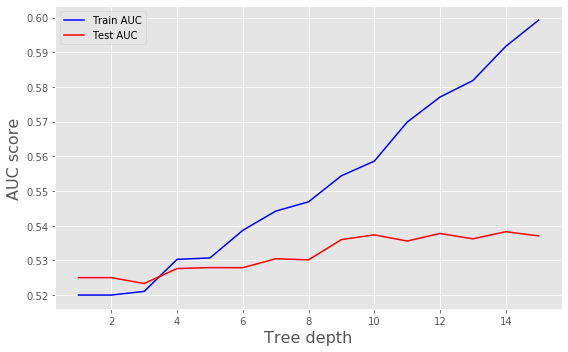

In [26]:
# find the optimal depth to narrow down search and avoid over fitting
hlf.find_optimal_depth(x_train, x_test, y_train, y_test)

In [17]:
tree = DecisionTreeClassifier(random_state=10)  
tree.fit(x_train, y_train)

# predict
tree_pred = tree.predict(x_test)

# get prediction accuracy
_, _ = hlf.print_metrics(y_test, tree_pred, print_score=True)

Recall Score: 52.24
Accuracy Score: 52.16


In [54]:
# using random search to find the optimal hyper paramters
tree_dist = {"max_depth": randint(9, 14),
             "max_features": randint(1, 50),
             "min_samples_leaf": randint(2, 1000),
             "min_samples_split": randint(2, 1000),
            }

tree_clf = RandomizedSearchCV(DecisionTreeClassifier(), tree_dist, n_iter=1500)
tree_clf.fit(x_train, y_train.values.ravel())

D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='b

In [55]:
# fit the optimal tree
optimal_tree = tree_clf.best_estimator_
optimal_tree.fit(x_train, y_train.values.ravel())
# predict
opt_tree_pred = optimal_tree.predict(x_test)

# get prediction accuracy
_, _ = hlf.print_metrics(y_test, opt_tree_pred, print_score=True)

Recall Score: 78.11
Accuracy Score: 54.39


In [ ]:
hlf.plot_confusion_matrix(y_test, opt_tree_pred)

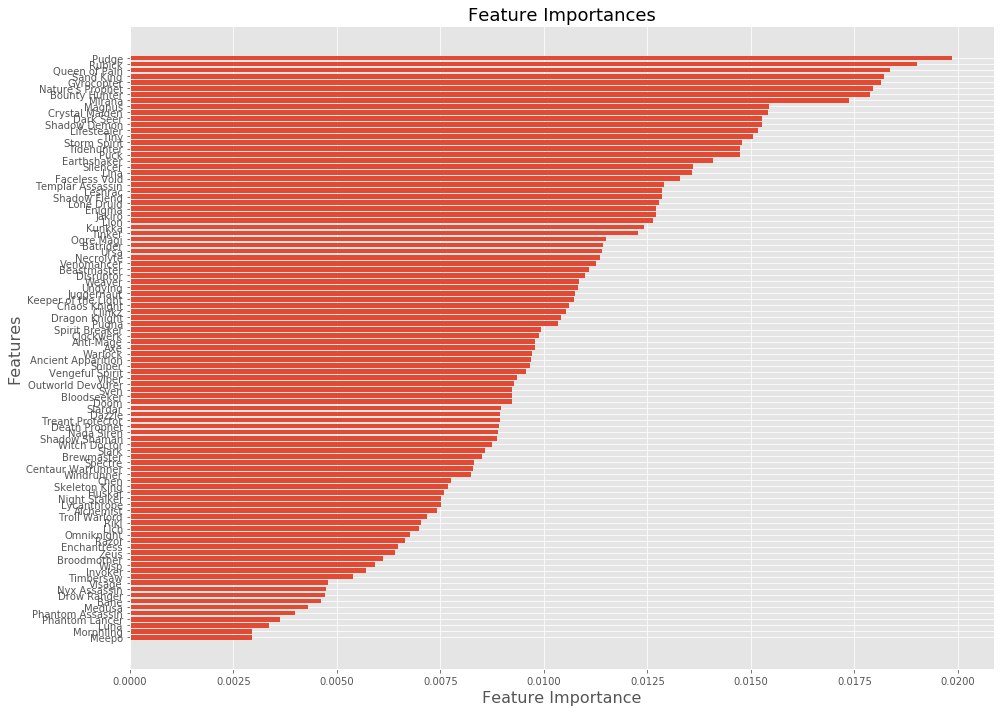

In [53]:
hlf.plot_feature_importance(optimal_tree, x_test, n=98)

In [20]:
print(f"Best paramaters: {tree_clf.best_params_}")

NameError: name 'tree_clf' is not defined

### Optimal Parameters: {{'max_depth': 7, 'max_features': 12, 'min_samples_leaf': 234, 'min_samples_split': 9}}

#### Recall - 50.05% 

#### Accuracy = 53.36%

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
# get a baseline how random forest performs
forest = RandomForestClassifier(random_state=123)
forest.fit(x_train, y_train.values.ravel())

# predcit
forest_test_pred = forest.predict(x_test)

# check prediction metrics
f_recall, f_acc = hlf.print_metrics(y_test, forest_test_pred, print_score=True)

### Random Forest using randon search

In [ ]:
# using random search to find the optimal hyper paramters
forest_dist = {"max_depth": randint(9, 14),
               "max_features": randint(1, 16),
               "min_samples_leaf": randint(2, 1000),
               "min_samples_split": randint(2, 1000),
              }

forest_grid = RandomizedSearchCV(RandomForestClassifier(), forest_dist, n_iter=1500)
forest_grid.fit(x_train, y_train.values.ravel())

In [ ]:
# fit the optimal random forest
optimal_forest = forest_grid.best_estimator_
optimal_forest.fit(x_train, y_train.values.ravel())

# predict
opt_forest_pred = optimal_forest.predict(x_test)

# get prediction metrics
_, _ = hlf.print_metrics(y_test, opt_forest_pred, print_score=True)
print(f"Random forest best paramaters: {forest_grid.best_params_}")

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_forest_pred)

In [ ]:
hlf.plot_feature_importance(optimal_forest, x_test)

### Optimal Parameters: {'max_depth': 6, 'max_features': 15, 'min_samples_leaf': 149, 'min_samples_split': 331}

#### Recall Score: 52.18%

#### Accuracy Score: 56.19%

# AdaBoost

In [50]:
# get a baseline on how ada boost performs
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train.values.ravel())

# predict
adaboost_test_pred = adaboost.predict(x_test)

# test how badly model performs 
_, _ = hlf.print_metrics(y_test, adaboost_test_pred, print_score=True)

Recall Score: 55.51
Accuracy Score: 56.81


### AdaBoost Using Gridsearch

In [ ]:
adaboost_param_grid = {'n_estimators': [70, 150, 200, 250, 270, 300],
                       'learning_rate': [0.4, 0.2, 0.1]
                      }

#fit adaboost with a paramters grid
ada_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=4)
ada_grid_search.fit(x_train, y_train.values.ravel())

In [ ]:
opt_ada = ada_grid_search.best_estimator_

# predict 
adagrid_pred = opt_ada.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, adagrid_pred, print_score=True)

# best paramters
best_ada_params = ada_grid_search.best_params_
print(f"AdaBoost best parameters: {best_ada_params}")

In [ ]:
# changing the hyper paramaters grid and running again to see if I could get better accuracy
adaboost_param_grid2 = {'n_estimators': [20, 40, 50, 70, 100],
                        'learning_rate': [0.3, 0.4, 0.6]
                       }

# fitting a new model with different hyper paramaters
ada_grid_search2 = GridSearchCV(adaboost, adaboost_param_grid2, scoring='accuracy', cv=4)
ada_grid_search2.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred2 = ada_grid_search2.predict(x_test)

# test how well the model performs 
_, _ = hlf.print_metrics(y_test, adagrid_pred2, print_score=True)

In [ ]:
# fit the optimal paramaters for adaboost
optimal_ada = ada_grid_search2.best_estimator_
optimal_ada.fit(x_train, y_train)

# predict
opt_ada_pred = optimal_ada.predict(x_test)

# get prediction accuracy
_, _ = hlf.print_metrics(y_test, opt_ada_pred, print_score=True)

# best paramters
best_ada_params2 = ada_grid_search2.best_params_
print(best_ada_params2)

In [ ]:
print(f" F1 Score (Optimal Adaboost): {round(f1_score(y_test, opt_ada_pred), 2)}")

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_ada_pred)
# plt.savefig('ada_cm.png')

In [ ]:
hlfs.plot_feature_importance(optimal_ada, x_test, n=16)
# plt.savefig('ada_feat_import.png')

In [ ]:
hlf.plot_roc_curve(optimal_ada, x_test, y_test)
# plt.savefig('ada_roc_curve.png')

### Optimal Parameters: {'learning_rate': 0.6, 'n_estimators': 50}
#### Recall = 55.82%
#### Accuracy = 56.59%

# XGBoost

In [32]:
import xgboost as xgb

# check baseline accuracy for xgboost
xgbooster = xgb.XGBClassifier()
xgbooster.fit(x_train, y_train.values.ravel())

# predict
xgb_pred = xgbooster.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, xgb_pred, print_score=True)

Recall Score: 53.74
Accuracy Score: 56.52


In [ ]:
plot_confusion_matrix(y_test, xgb_pred)

In [ ]:
plot_feature_importance(xgbooster, x_train, n=30)

### XGBoost Using Gridsearch

In [ ]:
xg_param_grid = {'learning_rate': [0.4, 0.6], 'max_depth': [5, 7], 
                 'min_child_weight': [4, 5, 6], 'subsample': [0.6, 0.7],
                 'n_estimators': [50, 70, 90, 120]
                }

In [ ]:
xg_grid = GridSearchCV(xgbooster, xg_param_grid, scoring='accuracy', cv=3, n_jobs=1,
                       verbose=1)
xg_grid.fit(x_train, y_train.values.ravel())

# predict
xg_grid_preds = xg_grid.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, xg_grid_preds, print_score=True)
best_parameters = xg_grid.best_params_

print(best_parameters)

In [ ]:
# running the model again with slightly similar hyperparamaters
xg_param_grid2 = {'learning_rate': [0.2, 0.4], 'max_depth': [4, 5, 6], 
                 'min_child_weight': [6, 7], 'subsample': [0.7, 0.8],
                 'n_estimators': [20, 30, 50, 70, 100]
                }

In [ ]:
xg_grid2 = GridSearchCV(xgbooster, xg_param_grid2, scoring='accuracy', cv=3, n_jobs=1,
                       verbose=True)
xg_grid2.fit(x_train, y_train.values.ravel())

# predict
xg_grid_preds2 = xg_grid2.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, xg_grid_preds2, print_score=True)
best_parameters2 = xg_grid2.best_params_

print(f"Best parameters: {best_parameters2}")

In [ ]:
# run xgboost again with the new paramaters
opt_xgb = xg_grid2.best_estimator_
opt_xgb.fit(x_train, y_train.values.ravel())

# predict
opt_xgb_pred = opt_xgb.predict(x_test)

# test how badly the model performs 
opt_xgb_recall, opt_xgb_accuracy = hlf.print_metrics(y_test, opt_xgb_pred, print_score=True)

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_xgb_pred)

In [ ]:
hlf.plot_feature_importance(opt_xgb, x_test, n=15)

# Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

# check the baseline how logistic regression works
log_reg = LogisticRegression(fit_intercept = False, C = 1e12)
log_mod = log_reg.fit(x_train, y_train)

# predict
log_pred = log_reg.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, log_pred, print_score=True)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall Score: 56.64
Accuracy Score: 56.71


### Logistic regression using Gridsearch

In [ ]:
log_grid = {"C": np.logspace(0, 12, 20),
            'penalty': ['l1', 'l2']}

log_reg_grid = GridSearchCV(log_mod, log_grid, scoring="accuracy", cv=4, verbose=1)
log_reg_grid = log_reg_grid.fit(x_train, y_train.values.ravel())

# predict
grid_log_pred = log_reg.predict(x_test)

# test how badly the model performs 
_, _ = hlf.print_metrics(y_test, grid_log_pred, print_score=True)

In [ ]:
opt_logis = log_reg_grid.best_estimator_
opt_logis.fit(x_train, y_train)

opt_logis_pred = opt_logis.predict(x_test)
# test how well the model performs 
_, _ = hlf.print_metrics(y_test, opt_logis_pred, print_score=True)
print(f"Best parameters: {log_reg_grid.best_params_}")

In [ ]:
hlf.plot_confusion_matrix(y_test, opt_logis_pred)

In [ ]:
hlf.plot_roc_curve(opt_logis, x_test, y_test)

### Optimal

# SVM


In [40]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# Reduce dimonsionality so my computer won't explode trying to run SVM with 30k observations and 114 dimensions
x_reduced = PCA(n_components=30).fit_transform(df)

In [41]:
rx_train, rx_test, ry_train, ry_test = train_test_split(x_reduced, labels,
                                                        test_size=0.25,
                                                        random_state=123)


In [43]:
# to get a base line run model with default paramters and different kernels
SVMp = SVC(kernel='poly', max_iter=2000)
SVMp.fit(rx_train, ry_train)
print(SVMp.score(rx_test, ry_test))

D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.502


In [44]:
# to get a base line run model with default paramters and different kernels
SVMs = SVC(kernel='rbf', max_iter=2000)
SVMs.fit(rx_train, ry_train)
print(SVMs.score(rx_test, ry_test))

D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Programs\Anaconda\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.5032


In [38]:
# to get a base line run model with default paramters
SVM = LinearSVC(max_iter=3500)
SVM.fit(rx_train, ry_train)
print(SVM.score(rx_test, ry_test))

0.5678666666666666


### LinearSVC using Gridsearch

In [ ]:
c = np.logspace(start=-20, stop=400, base=1.05)
svm_grid = {'C': c}

svm_grid = GridSearchCV(SVM, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svm_grid.fit(rx_train, ry_train)

In [ ]:
opt_svm = svm_grid.best_estimator_
opt_svm.fit(rx_train, ry_train)

# predict
opt_svm_pred = opt_svm.predict(rx_test)

# check how badly the model predicts
opt_svm_recall, opt_svm_acc = print_metrics(ry_test, opt_svm_pred, print_score=True)
opt_svm.score(rx_test, ry_test)

In [ ]:
# changing the penalty from 'l2' to 'l1' and check how badly the model predicts
SVMl1 = LinearSVC(penalty='l1', max_iter=3500, dual=False)

svml1_grid = GridSearchCV(SVMl1, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svml1_grid.fit(rx_train, ry_train)

In [ ]:
optl1_svm = svml1_grid.best_estimator_
optl1_svm.fit(rx_train, ry_train)

# predict
opt_svml1_pred = optl1_svm.predict(rx_test)

# test how well the model performs 
opt_svml1_recall, opt_svml1_acc = print_metrics(ry_test, opt_svml1_pred, print_score=True)
optl1_svm.score(rx_test, ry_test)